In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspect = inspect(engine)
inspect.get_table_names()

['measurement', 'station']

In [11]:
columns = inspect.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspect.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
m_results = session.query(Measurement.date, Measurement.prcp).\
order_by(Measurement.date.desc()).all()
m_results_df = pd.DataFrame(m_results)
m_results_df.head()

,date,prcp
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [16]:
m_results_df['date'] = m_results_df['date'].str.replace("-","").astype(int)


In [17]:

m_results_df.head()

,date,prcp
0,20170823,0.00
1,20170823,0.00
2,20170823,0.08
3,20170823,0.45
4,20170822,0.00


In [42]:
precip_12_df = m_results_df[(m_results_df.date <= 20170823) & (m_results_df.date >= 20160823)]
precip_12_df = precip_12_df.sort_values(by=['date'])
precip_12_df.dropna().head()

,date,prcp
2229,20160823,0.70
2223,20160823,0.00
2224,20160823,0.15
2228,20160823,1.79
2227,20160823,0.02


In [73]:

y_axis = precip_12_df['prcp']
x_axis = np.arange(len(precip_12_df['prcp']))


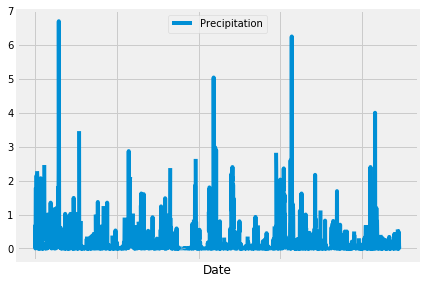

In [111]:
plt.plot(x_axis, y_axis, label="Precipitation")
plt.tight_layout()
plt.legend(loc="upper center")
plt.tick_params(axis="x", labelbottom=False)
plt.xlabel("Date")


plt.show()

![precipitation](Images/precipitation.png)

In [45]:
precip_12_df.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [167]:
# Design a query to show how many stations are available in this dataset?

station_df = pd.read_sql(
    'SELECT station FROM station',engine)
station_df

,station
0,USC00519397
1,USC00513117
2,USC00514830
3,USC00517948
4,USC00518838
5,USC00519523
6,USC00519281
7,USC00511918
8,USC00516128


In [127]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active_df = pd.read_sql(
   '''SELECT station, 
    COUNT (station) AS most_active
    FROM measurement
    GROUP BY station
    ORDER BY most_active DESC
    ''' ,engine)
station_active_df

,station,most_active
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [166]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_df = pd.read_sql(
    '''SELECT station, 
              MAX(tobs) AS max_temp,
              MIN(tobs) AS min_temp,
              AVG(tobs) AS avg_temp
       FROM measurement
       GROUP BY station
       
    '''
,engine)

temp_df

,station,max_temp,min_temp,avg_temp
0,USC00511918,87.0,53.0,71.615968
1,USC00513117,85.0,59.0,72.689184
2,USC00514830,85.0,58.0,74.873297
3,USC00516128,84.0,58.0,70.915008
4,USC00517948,87.0,58.0,74.684402
5,USC00518838,83.0,58.0,72.724070
6,USC00519281,85.0,54.0,71.663781
7,USC00519397,87.0,56.0,74.553231
8,USC00519523,85.0,56.0,74.543649


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [175]:
histo_df = pd.read_sql(
                        '''SELECT date, tobs
                           FROM measurement
                           WHERE station = 'USC00519281' 
                           AND date >= '2016-08-18'
                        ''', engine)
histo_df.head()


,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


<BarContainer object of 357 artists>

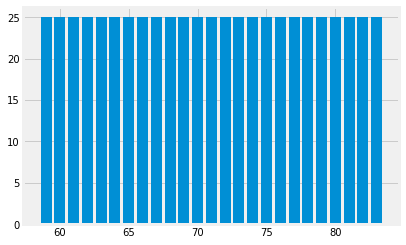

In [190]:
histo_df["tobs"] = histo_df["tobs"].astype(int)
y_axis = histo_df["tobs"].nunique()
x_axis = histo_df["tobs"]
plt.bar(x_axis, y_axis)


In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [33]:
# Plot the daily normals as an area plot with `stacked=False`
